# Plot System

e:\anaconda3\envs\kwant\Lib\site-packages\kwant\_plotter.py:77: RuntimeWarning: plotly is not available, if other engines are unavailable, only iterator-providing functions will work
  warnings.warn("plotly is not available, if other engines are unavailable,"


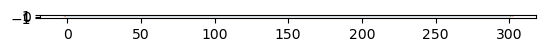

In [1]:
from system import*

sys = sys_conds(B,omega,mu,mu_lead=2*t,t_lead=t).finalized()

def site_color(site):
    # print(site)
    x = site
    if x == 0 or x == L+2 :
        return 'green'    # edge sites
    else:
        return 'lightblue'   # bulk sites
kwant.plot(sys, site_color=site_color);



# Bands,Ldos,eigenvalues

Energy Gap: 0.0032346358463069547


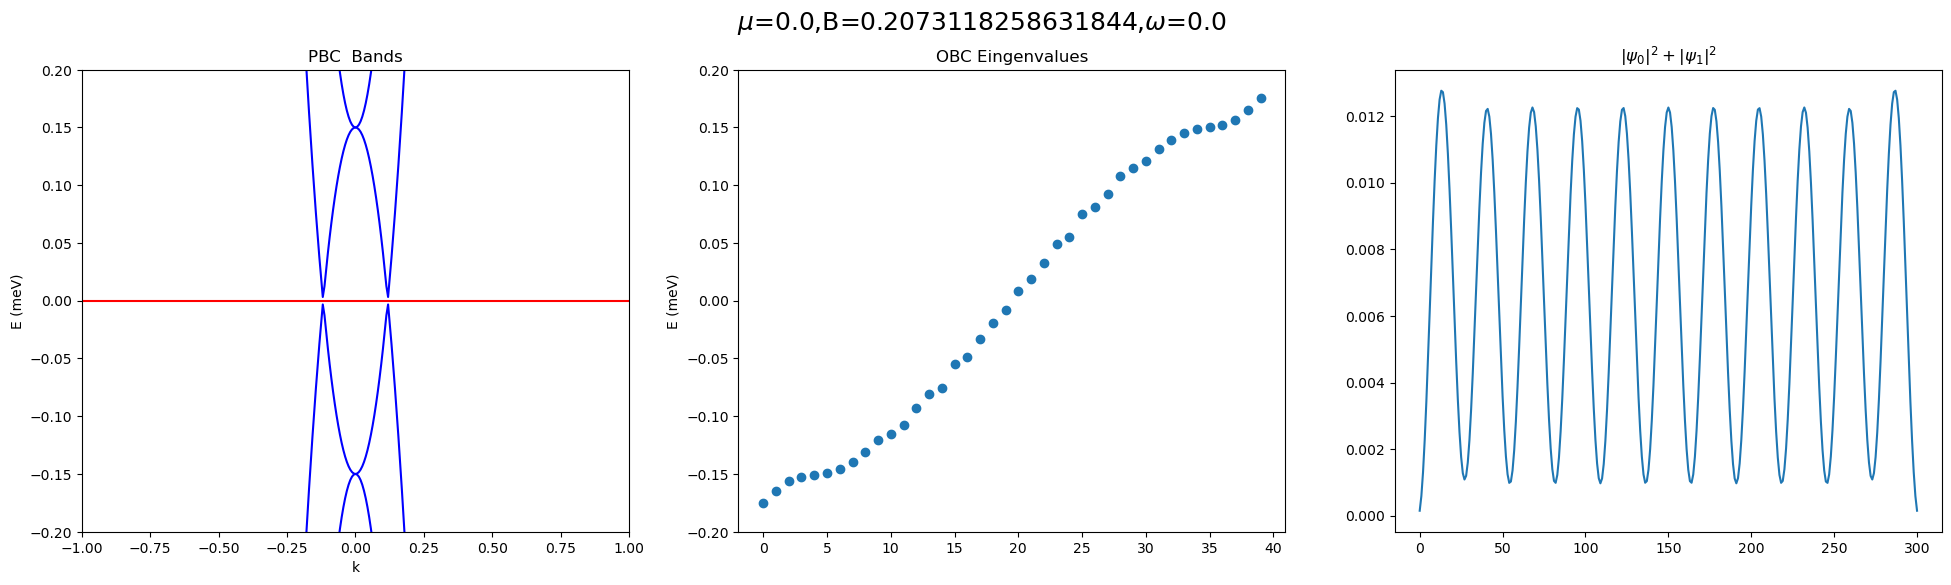

In [18]:
from system import*

''' Tunable parameters '''
B     = 0.15/(gmu/2)             # external magnetic field [T]
mu    = 0.0             # chemical potential [meV]
omega = 0.0             # frequncy/energy [meV]


gamma = 0
def self_eng(omega):
    numerator   = omega * kron(tau_0, sigma_0) + delta0 * kron(tau_x, sigma_0)
    denominator = sqrt(delta0**2 - omega**2)
    return  -gamma * numerator / denominator


def sys_bands(B, omega, mu, PBC=True):
    if PBC:
        sys = kwant.Builder(kwant.TranslationalSymmetry((1,0)))
    else:
        sys = kwant.Builder()

    lat = kwant.lattice.square(a=1,norbs=4,name='wire')
    es = 1e-3
    
    def system_shape(pos):
        return -1  < pos[0] < L + 1  and  0-es < pos[1] < 1

    def onsite_SC(site):
        return (2 * t - mu) * kron(tau_z,sigma_0) + self_eng(omega) + 1/2 * gmu * B * kron(tau_0,sigma_x) 
    
    def hoppingx(site1,site2):
        x,y = site1.pos
        return  -t * kron(tau_z,sigma_0) + 1j * alpha/2 * kron(tau_z,sigma_y) 

    sys[lat.shape(system_shape, (0, 0))] = onsite_SC
    sys[kwant.builder.HoppingKind((1, 0), lat, lat)] = hoppingx
    return sys

def main():
    '''sys_bands,omega=0'''
    sys = sys_bands(B, omega, mu, PBC=True).finalized()

    band_sys = kwant.physics.Bands(sys)
    momenta = np.linspace(-pi, pi, 1001)
    eng_sys = np.array([band_sys(k) for k in momenta])
    zero = np.zeros(len(momenta))


    '''eigenvalues and states'''
    system = sys_bands(B, omega, mu, PBC=False).finalized()
    hamiltonian = system.hamiltonian_submatrix(sparse=True)
    energies,states = eigsh(hamiltonian, k=40, sigma=1e-10, return_eigenvectors=True)
    eng = np.sort(energies)


    '''|psi0|^2+|psi1|^2'''
    rho = kwant.operator.Density(system)
    density = rho(states[:,0]) + rho(states[:,1])  # two lowest states

    # BdG gap
    min_positive_energy = np.min(eng_sys[eng_sys > 0])
    max_negative_energy = np.max(eng_sys[eng_sys < 0])
    gap = (min_positive_energy - max_negative_energy)/2
    print("Energy Gap:", gap)



    '''plotting'''
    subtitle_dict = {'fontsize': 18}
    title_dict = {'fontsize': 12}
    plt.figure(figsize=(24,6))
    plt.suptitle(f'$\\mu$={mu},B={B},$\\omega$={omega}', **subtitle_dict)

    # bands
    plt.subplot(1,3,1)
    plt.plot(momenta, eng_sys,'b')
    plt.plot(momenta, zero,'r')
    plt.xlabel('k')
    plt.ylabel('E (meV)')   
    plt.ylim(-0.2,0.2)
    plt.xlim(-1,1)
    plt.title('PBC  Bands', **title_dict)

    # obc eigenvalues
    plt.subplot(1,3,2)
    plt.plot(eng,'o')
    plt.ylim(-0.2,0.2)
    plt.ylabel('E (meV)')   
    plt.title('OBC Eingenvalues', **title_dict)

    # ldos
    Xs = np.arange(0, L + 1)
    plt.subplot(1,3,3)
    plt.plot(Xs,density)
    plt.title('$|\\psi_0|^2+|\\psi_1|^2$', **title_dict)
    plt.show()

    # plt.savefig('Bands.pdf', format='pdf', dpi=300, bbox_inches='tight')   # PDF
    # plt.savefig('Bands.eps', format='eps', dpi=300, bbox_inches='tight')   # EPS
    # plt.savefig('Bands.jpg', format='jpg', dpi=300, bbox_inches='tight')   # JPG



if __name__ == '__main__':
    main()


# Phase

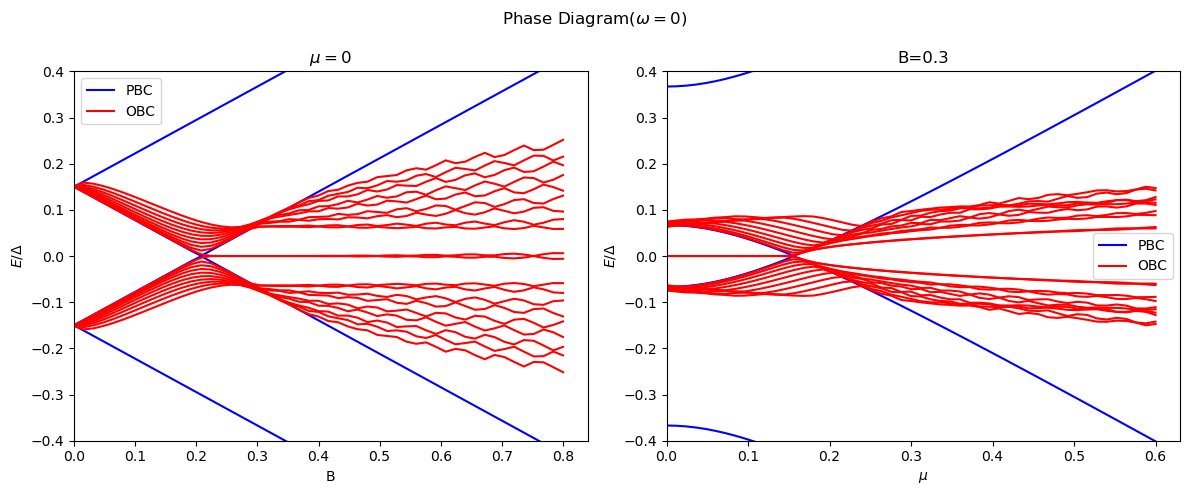

In [15]:
''' the symbol 'B' in Phase Diagram is the magnetic field rather than the zeeman field.'''

def compute_band_structure_pbc(param_range, B, mu, xlabel):
    E = []
    for param in param_range:
        sys = sys_bands(PBC=True, omega=omega, B=B if xlabel != 'B' else param, mu=mu if xlabel != '$\\mu$' else param).finalized()
        band_sys = kwant.physics.Bands(sys)
        E.append(band_sys(0))
    return E

def compute_band_structure_obc(param_range, B, mu, xlabel):
    E = []
    for param in param_range:
        sys = sys_bands(PBC=False, omega=omega, B=B if xlabel != 'B' else param, mu=mu if xlabel != '$\\mu$' else param).finalized()
        ham = sys.hamiltonian_submatrix()
        eng = eigsh(ham, k=20, sigma=1e-10, return_eigenvectors=False)
        eng_sorted = np.sort(eng)
        E.append(eng_sorted)
    return E



# Compute data
B_range = np.linspace(0, 0.8, 51)
mu_range = np.linspace(0, 0.6, 51)

B_FIX = 0.3
mu_FIX = 0

E_B_pbc = compute_band_structure_pbc(B_range, B=0, mu=mu_FIX, xlabel='B')
E_B_obc = compute_band_structure_obc(B_range, B=0, mu=mu_FIX, xlabel='B')
E_mu_pbc = compute_band_structure_pbc(mu_range, B=B_FIX, mu=0, xlabel='$\\mu$')
E_mu_obc = compute_band_structure_obc(mu_range, B=B_FIX, mu=0, xlabel='$\\mu$')


# Plot results
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle(f'Phase Diagram($\\omega=0$)')

# Energy vs Magnetic Field
axes[0].plot(B_range, E_B_pbc, 'b')
axes[0].plot(B_range, E_B_obc, 'r')
axes[0].set_xlabel('B')
axes[0].set_ylabel('$E/\\Delta$')
axes[0].set_ylim(-0.4,0.4)
axes[0].set_xlim(0,)
axes[0].set_title(f'$\\mu={mu_FIX}$')

axes[0].plot(B_range[0], E_B_pbc[0][0], 'b', label='PBC')  
axes[0].plot(B_range[0], E_B_obc[0][0], 'r', label='OBC')
axes[0].legend()

# Energy vs Chemical Potential
axes[1].plot(mu_range, E_mu_pbc, 'b')
axes[1].plot(mu_range, E_mu_obc, 'r')
axes[1].set_xlabel('$\\mu$')
axes[1].set_ylabel('$E/\\Delta$')
axes[1].set_ylim(-0.4,0.4)
axes[1].set_xlim(0,)
axes[1].set_title(f'B={B_FIX}')

axes[1].plot(B_range[0], E_B_pbc[0][0], 'b', label='PBC')  
axes[1].plot(B_range[0], E_B_obc[0][0], 'r', label='OBC')
axes[1].legend()

plt.tight_layout()
plt.show()




# B，mu phase (调试中)

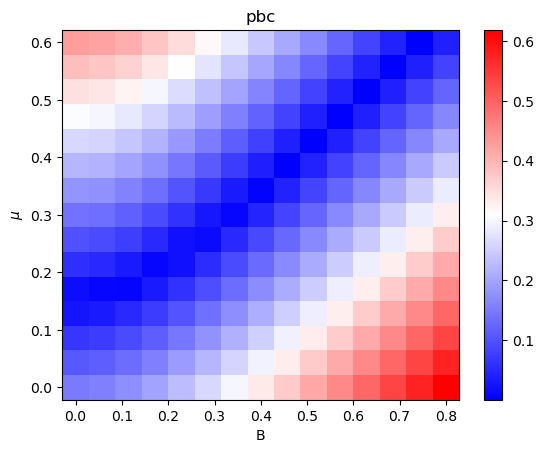

0.06706431754500004
2.4411030721988998e-06


In [2]:
from system import*

''' Tunable parameters '''
B     = 0.3             # external magnetic field [T]
mu    = 0.0             # chemical potential [meV]
omega = 0.0             # frequncy/energy [meV]

def compute_phase_pbc(B_range, mu_range):
    E = np.zeros((len(B_range),len(mu_range)))
    for i,B in enumerate(B_range):
        for j,mu in enumerate(mu_range):
            sys = sys_bands(B, omega, mu, PBC=True).finalized()
            band_sys = kwant.physics.Bands(sys)
            E[i,j] = np.min(np.abs(band_sys(0)))
    return E

def compute_phase_obc(B_range, mu_range):
    E = np.zeros((len(B_range),len(mu_range)))
    for i,B in enumerate(B_range):
        for j,mu in enumerate(mu_range):
            sys = sys_bands(B, omega, mu, PBC=False).finalized()
            ham = sys.hamiltonian_submatrix()
            eng = eigsh(ham, k=10, sigma=1e-10, return_eigenvectors=False)
            # eng_sorted = np.sort(eng)
            E[i,j] = np.min(np.abs(eng))
    return E


# Compute data
B_range = np.linspace(0, 0.8, 15)
mu_range = np.linspace(0, 0.6, 15)
E_pbc = compute_phase_pbc(B_range, mu_range)
# E_obc = compute_phase_obc(B_range, mu_range)



X, Y = np.meshgrid(B_range, mu_range)
plt.figure()
plt.pcolormesh(X, Y, E_pbc, cmap='bwr', shading='auto') 
plt.title('pbc')
plt.xlabel('B')
plt.ylabel('$\\mu$')
cbar = plt.colorbar()  
# cbar.set_label('2e^2/h', fontsize=12) 
plt.show()


B = 0.3
mu = 0


sys = sys_bands(B, omega, mu, PBC=True).finalized()
band_sys = kwant.physics.Bands(sys)
print(np.min(np.abs(band_sys(0))))



sys = sys_bands(B, omega, mu, PBC=False).finalized()
ham = sys.hamiltonian_submatrix()
eng = eigsh(ham, k=10, sigma=1e-10, return_eigenvectors=False)

print(np.min(np.abs(eng)))


# T=0, 1D conductance

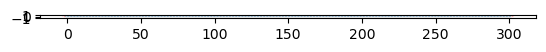

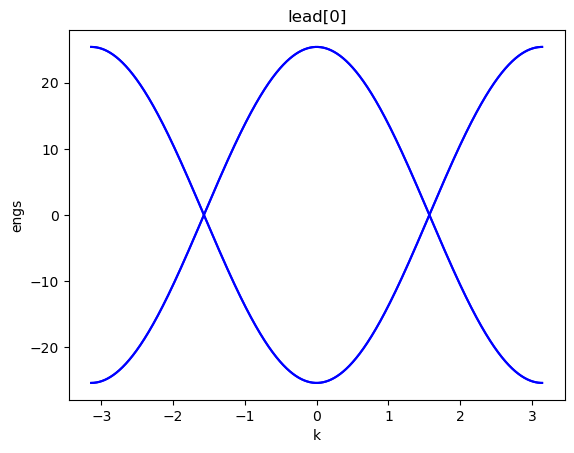

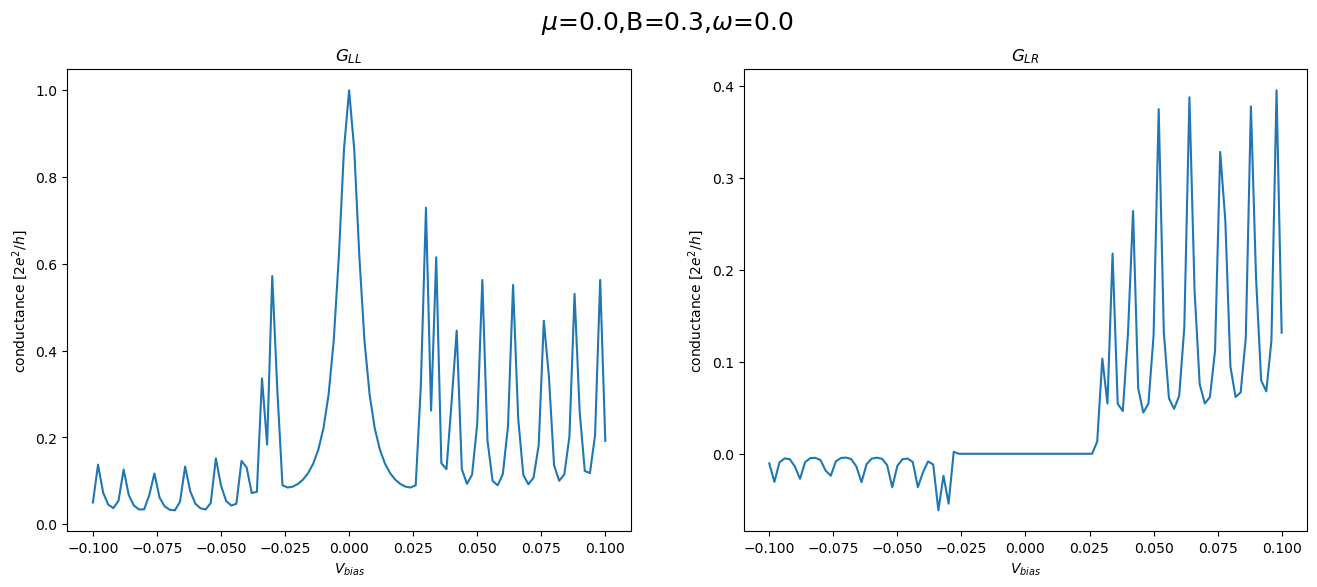

6.296146392822266


In [8]:
from system import*

''' Tunable parameters '''
B     = 0.3             # external magnetic field [T]
mu    = 0.0             # chemical potential [meV]
omega = 0.0             # frequncy/energy [meV]

def main():
    '''lead bands'''
    system = sys_conds(B, omega, mu)
    system = system.finalized()
    kwant.plot(system)

    band_lead = kwant.physics.Bands(system.leads[0])
    momenta = np.linspace(-pi, pi, 2001)
    eng_lead = [band_lead(k) for k in momenta]

    '''plot'''    
    plt.figure()
    plt.plot(momenta, eng_lead,'b')
    plt.xlabel('k')
    plt.ylabel('engs')
    plt.title('lead[0]')
    plt.show()

    t1 = time.time()
    bias = np.linspace(-0.1,0.1,101)

    Conds_LL = np.zeros(len(bias))    
    Conds_LR = np.zeros(len(bias))
    for i in range(len(bias)):

        system = sys_conds(B,bias[i],mu).finalized()
        #GLL
        Conds_LL[i] = cal_local_conds(system,bias[i])
        #GLR
        Conds_LR[i] = cal_nonlocal_conds(system,bias[i])
        
    #GLL
    subtitle_dict = {'fontsize': 18}
    title_dict = {'fontsize': 12}
    
    plt.figure(figsize=(16,6))
    plt.suptitle(f'$\\mu$={mu},B={B},$\\omega$={omega}', **subtitle_dict)
    plt.subplot(1,2,1)
    plt.plot(bias, Conds_LL/2)  
    plt.xlabel(r"$V_{bias}$")
    plt.ylabel("conductance [$2e^2/h$]")
    plt.title('$G_{LL}$', **title_dict)

    #GLR
    plt.subplot(1,2,2)
    plt.plot(bias, Conds_LR/2)  
    plt.xlabel(r"$V_{bias}$")
    plt.ylabel("conductance [$2e^2/h$]")
    plt.title('$G_{LR}$', **title_dict)
    plt.show()    
    t2 = time.time()
    print(t2-t1)
    
if __name__ == '__main__':
    main()

# bias = 0,T=0，2D conds (参数调试中)

15.430571794509888


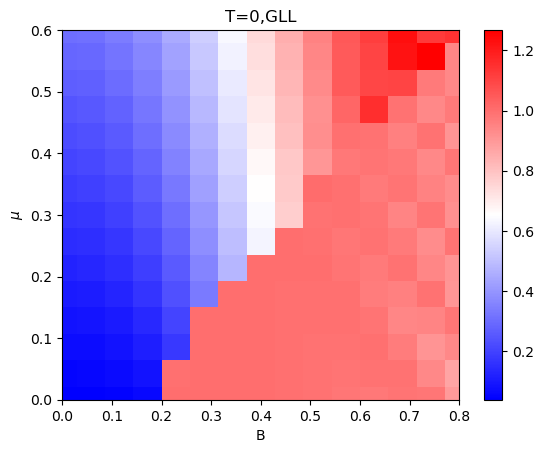

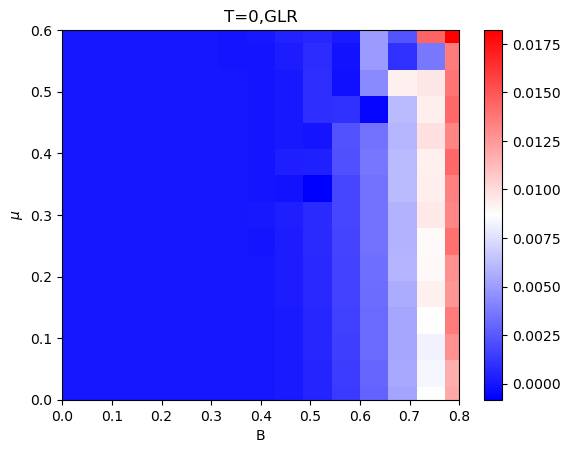

In [ ]:
from system import*

''' Tunable parameters '''
B = np.linspace(0,0.8,15)           # external magnetic field [T]
mu = np.linspace(0,0.6,15)          # chemical potential [meV]
omega = 0.0                         # frequncy/energy [meV]



'''GLL'''
t1 = time.time()
GLL = np.zeros((len(B),len(mu)))
for i in range(len(B)):
    for j in range(len(mu)):
        system = sys_conds(B[i],omega,mu[j]).finalized()
        GLL[i][j] = cal_local_conds(system,omega)
        # print('B=',B[i],'mu=',mu[j],GLL[i][j])
        
'''GLR'''
GLR = np.zeros((len(B),len(mu)))
for i in range(len(B)):
    for j in range(len(mu)):
        system = sys_conds(B[i],omega,mu[j])
        system = system.finalized()
        GLR[i][j] = cal_nonlocal_conds(system,omega)
        # print('B=',B[i],'mu=',mu[j],GLL[i][j])

t2 = time.time()
print(t2-t1)

def plot_cond(x,y,G,title):
    X, Y = np.meshgrid(x, y)
    # 绘制第一个图
    Z = np.array(G).T  
    plt.figure()
    plt.pcolormesh(X, Y, Z, cmap='bwr', shading='auto') 
    plt.title(title)
    plt.xlabel('B')
    plt.ylabel('$\\mu$')

    plt.xlim(np.min(x),np.max(x))
    plt.ylim(np.min(y),np.max(y))
    cbar = plt.colorbar()
    plt.show()

plot_cond(B,mu,GLL/2,'T=0,GLL')
plot_cond(B,mu,GLR/2,'T=0,GLR')

# mu = 0, T=0, 2D conductance

In [48]:
es = 1e-6


''' Tunable parameters '''
B = np.linspace(0,0.8,101)             # external magnetic field [T]
omega = np.linspace(-0.1,0.1,101)              # frequncy/energy [meV]
mu    = 0.3                                    # chemical potential [meV]

t1 = time.time()
GLL = np.zeros((len(B),len(omega)))
GLR = np.zeros((len(B),len(omega)))

for i in range(len(B)):
    for j in range(len(omega)):
        system = sys_conds(B[i],omega[j],mu).finalized()
        GLL[i][j] = cal_local_conds(system,omega[j])
        GLR[i][j] = cal_nonlocal_conds(system,omega[j])
t2 = time.time()
print(t2-t1)

def plot_cond(x,y,G,title):
    X, Y = np.meshgrid(x, y)
    Z = np.array(G).T  
    plt.figure()
    plt.pcolormesh(X, Y, Z, cmap='bwr', shading='auto') 
    plt.title(title)
    plt.xlabel('B')
    plt.ylabel('bias')

    plt.xlim(np.min(x),np.max(x))
    plt.ylim(np.min(y),np.max(y))
    # 添加 colorbar 并标注
    cbar = plt.colorbar()  
    cbar.set_label('$2e^2/h$', fontsize=12)  # 设置 colorbar 的标注
    plt.show()

plot_cond(B,omega,GLL/2,'T=0,GLL')
plot_cond(B,omega,GLR/2,'T=0,GLR')

1919.0316891670227


In [46]:
# plot_cond(B,omega,GLL/2,'T=0,GLL')
def plot_cond(x,y,G,title):
    X, Y = np.meshgrid(x, y)
    Z = np.array(G).T  
    plt.figure()
    plt.pcolormesh(X, Y, Z, cmap='bwr', shading='auto') 
    plt.title(title)
    plt.xlabel('B')
    plt.ylabel('bias')

    plt.xlim(np.min(x),np.max(x))
    plt.ylim(np.min(y),np.max(y))
    # 添加 colorbar 并标注
    cbar = plt.colorbar()  
    cbar.set_label('$2e^2/h$', fontsize=12)  # 设置 colorbar 的标注
    plt.show()
    
B = np.linspace(0,0.8,101)  
omega = np.linspace(-0.1,0.1,101)  
plot_cond(B,omega,GLR/2,'T=0,GLR')

# with tempreture

$G(E_{i})=\frac{2e^{2}}{h}\int\bar{T(E)}F_{T}(E-E_{i})dE$  \
with $F_{T}(E-E_{i})$ being the thermal broadening function  \
$F_{T}(E-E_{i})=-\frac{\partial}{\partial E}(\frac{1}{exp[(E-E_{i})/k_{B}T+1]})=\frac{1}{4k_{B}T}\frac{1}{cosh^{2}[\frac{E-E_{i}}{2*k_{B}T}]}$

In [49]:
# %matplotlib tk
bias = np.linspace(-0.1,0.1,201)

#KT energy in 50mK
KT = 4.31*1e-3 #meV

#all params are numbers
def dF(E, V, KT):
    return 1/(4*KT) * 1/(np.cosh((E-V)/(2.*KT))**2)


def Finite_Temp_Conds(G):
    #dimension of finite conds 
    g = np.zeros((len(G[:,0]),len(bias)))

    # rectangular integral
    for i in range(len(bias)):
        for j in range(len(omega)):
            g[:,i] += G[:,j] * dF(omega[j],bias[i],KT) * (omega[2] - omega[1])

    print(np.array(g).shape)

    return g

gLL = Finite_Temp_Conds(GLL)
gLR = Finite_Temp_Conds(GLR)

def plot_cond_GLL(x, y, cond, title):
    X, Y = np.meshgrid(x, y)
    Z = np.array(cond).T
    plt.pcolormesh(X, Y, Z, cmap='bwr', shading='auto') 
    plt.title(title)
    plt.xlabel('B')
    plt.ylabel('$V_{bias}$')
    
    cbar = plt.colorbar()  
    plt.savefig('GLR.svg', format='pdf', dpi=300, bbox_inches='tight')
    plt.show()


def plot_cond_GLR(x, y, cond, title):
    X, Y = np.meshgrid(x, y)
    Z = np.array(cond).T
    plt.figure()
    plt.pcolormesh(X, Y, Z, cmap='bwr', shading='auto', vmin=-0.02,vmax=0.02) 
    plt.title(title)
    plt.xlabel('B')
    plt.ylabel('bias')
    cbar = plt.colorbar()  
    cbar.set_label('2e^2/h', fontsize=12) 
    plt.show()



plt.figure()

plot_cond_GLL(B,bias,gLL/2,'T=50mK')
plot_cond_GLR(B,bias,gLR/2,'T=50mK')


(101, 201)
(101, 201)


In [42]:
omega

0.0

# Topological visibility(LL)

In [33]:
from system import*
import numpy as np

''' Tunable parameters '''
B = np.linspace(0,0.8,14)           # external magnetic field [T]
mu = np.linspace(0,0.6,14)          # chemical potential [meV]
omega = 0.0                         # frequncy/energy [meV]


def TV(sys,omega):
    smatrix = kwant.smatrix(sys,energy=omega,check_hermiticity=True)
    TV = np.linalg.det(smatrix.submatrix(0,0))
    return TV

t1 = time.time()
tv = np.zeros((len(B),len(mu)))
for i in range(len(B)):
    for j in range(len(mu)):
        system = sys_conds(B[i],omega,mu[j]).finalized()
        tv[i][j] = TV(system,omega)
        # print('B=',B[i],'mu=',mu[j],tv[i][j])
        


t2 = time.time()
print(t2-t1)


def plot_cond(x,y,G,title):
    X, Y = np.meshgrid(x, y)
    Z = np.array(G).T  
    plt.figure()
    plt.pcolormesh(X, Y, Z, cmap='viridis', shading='auto') 
    plt.title(title)
    plt.xlabel('B')
    plt.ylabel('$\\mu$')

    plt.xlim(np.min(x),np.max(x))
    plt.ylim(np.min(y),np.max(y))
    cbar = plt.colorbar()
    plt.show()

plot_cond(B,mu,tv,'TV')


C:\Users\linux\AppData\Local\Temp\ipykernel_44892\3701723121.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  tv[i][j] = TV(system,omega)
C:\Users\linux\AppData\Local\Temp\ipykernel_44892\3701723121.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  tv[i][j] = TV(system,omega)
C:\Users\linux\AppData\Local\Temp\ipykernel_44892\3701723121.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  tv[i][j] = TV(system,omega)
C:\Users\linux\AppData\Local\Temp\ipykernel_44892\3701723121.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  tv[i][j] = TV(system,omega)
C:\Users\linux\AppData\Local\Temp\ipykernel_44892\3701723121.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  tv[i][j] = TV(system,omega)
C:\Users\linux\AppData\Local\Temp\ipykernel_44892\3701723121.py:20: ComplexWarning: Casting complex values to real discards the imagina

6.881836414337158


C:\Users\linux\AppData\Local\Temp\ipykernel_44892\3701723121.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  tv[i][j] = TV(system,omega)
